In [1]:
import pandas as pd
import numpy as np
import os
%matplotlib inline

# Data Transformations

In [2]:
col_names = ["Status of existing checking account", "Duration in months", "Credit history", "Purpose", "Credit amount",
           "Savings account/bonds", "Present employment since", "Installment rate in percentage of disposable income",
           "Personal status and sex", "Other debtors / guarantors", "Present residence since", "Property", "Age in years",
           "Other installment plans", "Housing", "Number of existing credits at this bank", "Job", 
           "Number of people being liable to provide maintenance for", "Telephone", "Foreign worker", "Good flag"]

In [3]:
raw_data = pd.read_csv("german.data", sep=" ", names=col_names)

In [4]:
raw_data.corr("spearman")["Good flag"]

Duration in months                                          0.205685
Credit amount                                               0.087083
Installment rate in percentage of disposable income         0.073690
Present residence since                                     0.002553
Age in years                                               -0.112191
Number of existing credits at this bank                    -0.047316
Number of people being liable to provide maintenance for   -0.003015
Good flag                                                   1.000000
Name: Good flag, dtype: float64

In [5]:
raw_data['Good flag'] = raw_data["Good flag"] - 1

In [6]:
for column in raw_data.columns:
    if column != "Credit amount":
        print(raw_data.groupby(by=column)["Good flag"].sum()/raw_data.groupby(by=column)["Good flag"].count(), raw_data.groupby(by=column)["Good flag"].count())

Status of existing checking account
A11    0.492701
A12    0.390335
A13    0.222222
A14    0.116751
Name: Good flag, dtype: float64 Status of existing checking account
A11    274
A12    269
A13     63
A14    394
Name: Good flag, dtype: int64
Duration in months
4     0.000000
5     0.000000
6     0.120000
7     0.000000
8     0.142857
9     0.285714
10    0.107143
11    0.000000
12    0.273743
13    0.000000
14    0.250000
15    0.187500
16    0.500000
18    0.371681
20    0.125000
21    0.300000
22    0.000000
24    0.304348
26    0.000000
27    0.384615
28    0.333333
30    0.325000
33    0.333333
36    0.445783
39    0.200000
40    1.000000
42    0.272727
45    0.800000
47    0.000000
48    0.583333
54    0.500000
60    0.461538
72    1.000000
Name: Good flag, dtype: float64 Duration in months
4       6
5       1
6      75
7       5
8       7
9      49
10     28
11      9
12    179
13      4
14      4
15     64
16      2
18    113
20      8
21     30
22      2
24    184
26      1
27 

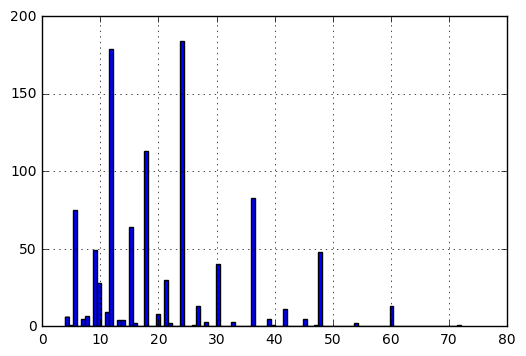

In [7]:
raw_data["Duration in months"].hist(bins=100)

In [42]:
raw_data["Duration in months binned"] = pd.cut(raw_data["Duration in months"], bins=[0, 6, 12, 15, 18, 24, 30, 36, 72])
raw_data["Age in years binned"] = pd.cut(raw_data["Age in years"], bins=[19, 25, 30, 35, 40, 50, 75])

In [64]:
numeric_vars = list(raw_data.dtypes.where(raw_data.dtypes == 'int64').dropna().index)
numeric_vars.remove('Good flag')
cat_vars = list(raw_data.dtypes.where(raw_data.dtypes != 'int64').dropna().index)

from sklearn.preprocessing import scale

raw_data_scaled = pd.DataFrame(scale(raw_data[numeric_vars]), columns=numeric_vars)
dummy_attr = pd.get_dummies(raw_data[cat_vars], dummy_na=True)
dummy_data = raw_data_scaled.merge(dummy_attr, left_index=True, right_index=True)
dummy_data['Good flag'] = raw_data['Good flag']

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.


## Data split

In [44]:
from sklearn.model_selection import train_test_split

In [67]:
# Preparing the data
train_data, oos_data = train_test_split(dummy_data, test_size=0.2, random_state=0, stratify=dummy_data["Good flag"])

attr = list(train_data.columns.copy())
attr.remove("Good flag")

X = train_data[attr].values
y = train_data["Good flag"].values

# Scikit Learn API

The Scikit-Learn's classes API consist of three main functions - 
<code>fit()</code> - fitting a given class to data;
<code>transform()</code> - transforms the data in a certain way;
<code>predict()</code> - gives the output of a model or algorithm.

# Algorithms

## Decision Tree - basics

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

tree_clf = DecisionTreeClassifier()

In [69]:
tree_clf.fit(X, y)
roc_auc_score(tree_clf.predict(X), y)

1.0

In [70]:
# From the above the tree is clearly overfitting. Let's investigate the structure of the tree
tree_clf.tree_.node_count

301

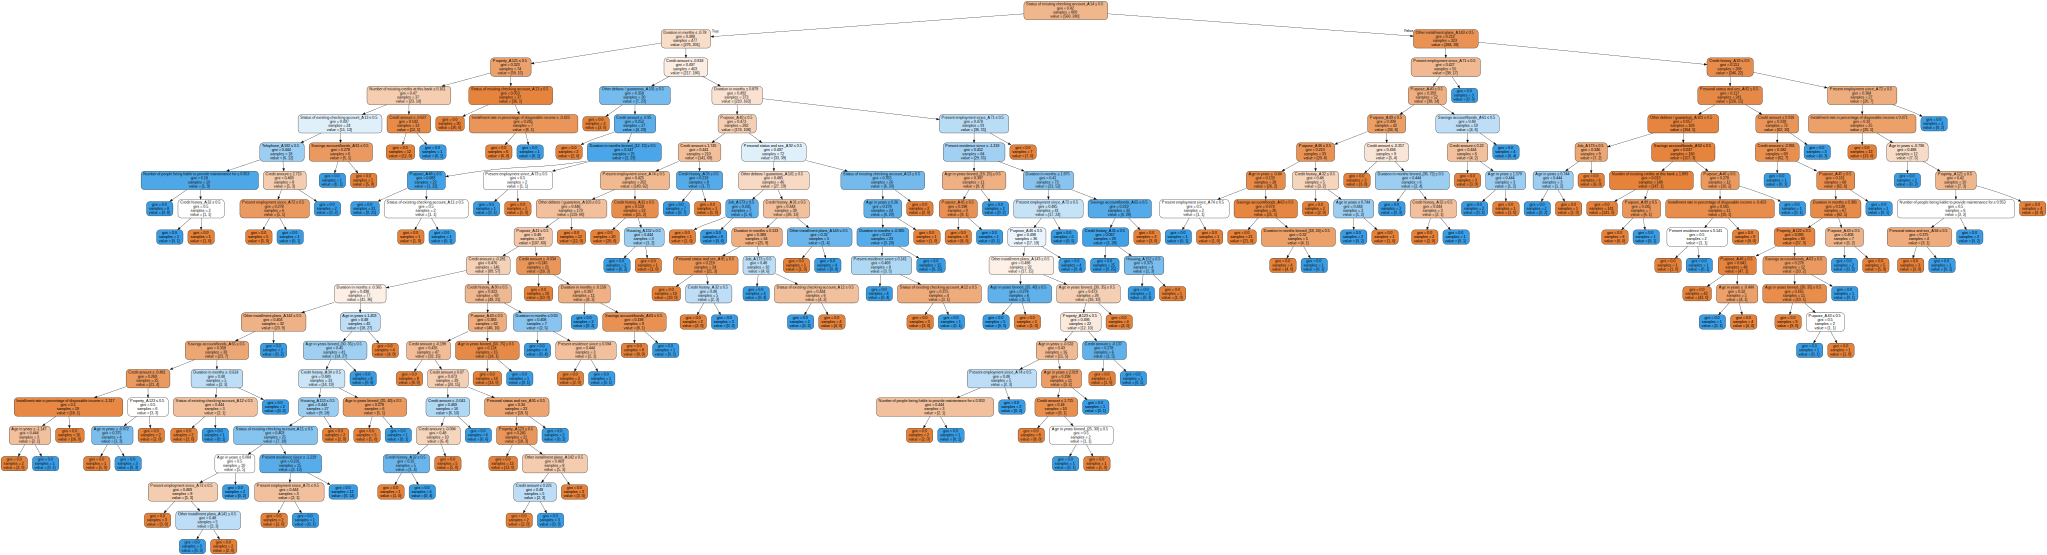

In [71]:
from sklearn.tree import export_graphviz
import graphviz

def graph_tree(clf, attr_list):
    dot_data = export_graphviz(clf, out_file=None, feature_names=attr_list, filled=True, rounded=True,
                           special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

graph_tree(tree_clf, attr)

## Decision trees - regularization

- <code>max_depth</code> - specifies how many "levels" a decision tree can have;

0.6675221532725555


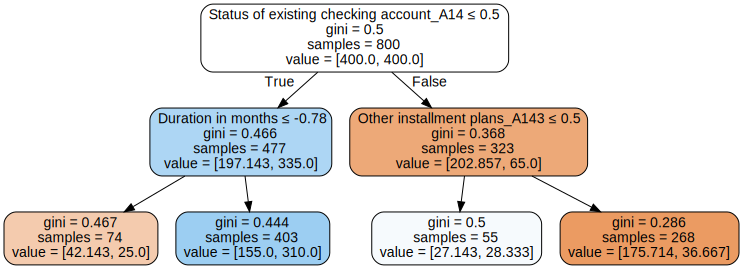

In [72]:
tree_clf2 = DecisionTreeClassifier(max_depth=2, class_weight='balanced')
tree_clf2.fit(X, y)
print(roc_auc_score(tree_clf2.predict(X), y))

graph_tree(tree_clf2, attr)

In [73]:
#Example of Gini-impurity at middle node
node_value = tree_clf2.tree_.value 
sum_vals = node_value[1].sum()
gini = node_value[1][0][0]/sum_vals * (1-node_value[1][0][0]/sum_vals) + node_value[1][0][1]/sum_vals * (1-node_value[1][0][1]/sum_vals)
print(gini)

0.4664438538804559


In [74]:
def feature_importances(clf):
    features = pd.DataFrame([clf.feature_importances_], columns=attr).transpose()
    return features.sort_values(by=0, ascending=False).head(n=5)

feature_importances(tree_clf2)

,0
Status of existing checking account_A14,0.725087
Duration in months,0.138202
Other installment plans_A143,0.136710
Job_A174,0.000000
Job_A173,0.000000


- <code>min_samples_split</code> - the minimum number of samples required to split a node (can be given asa fraction);

0.7205480947701713


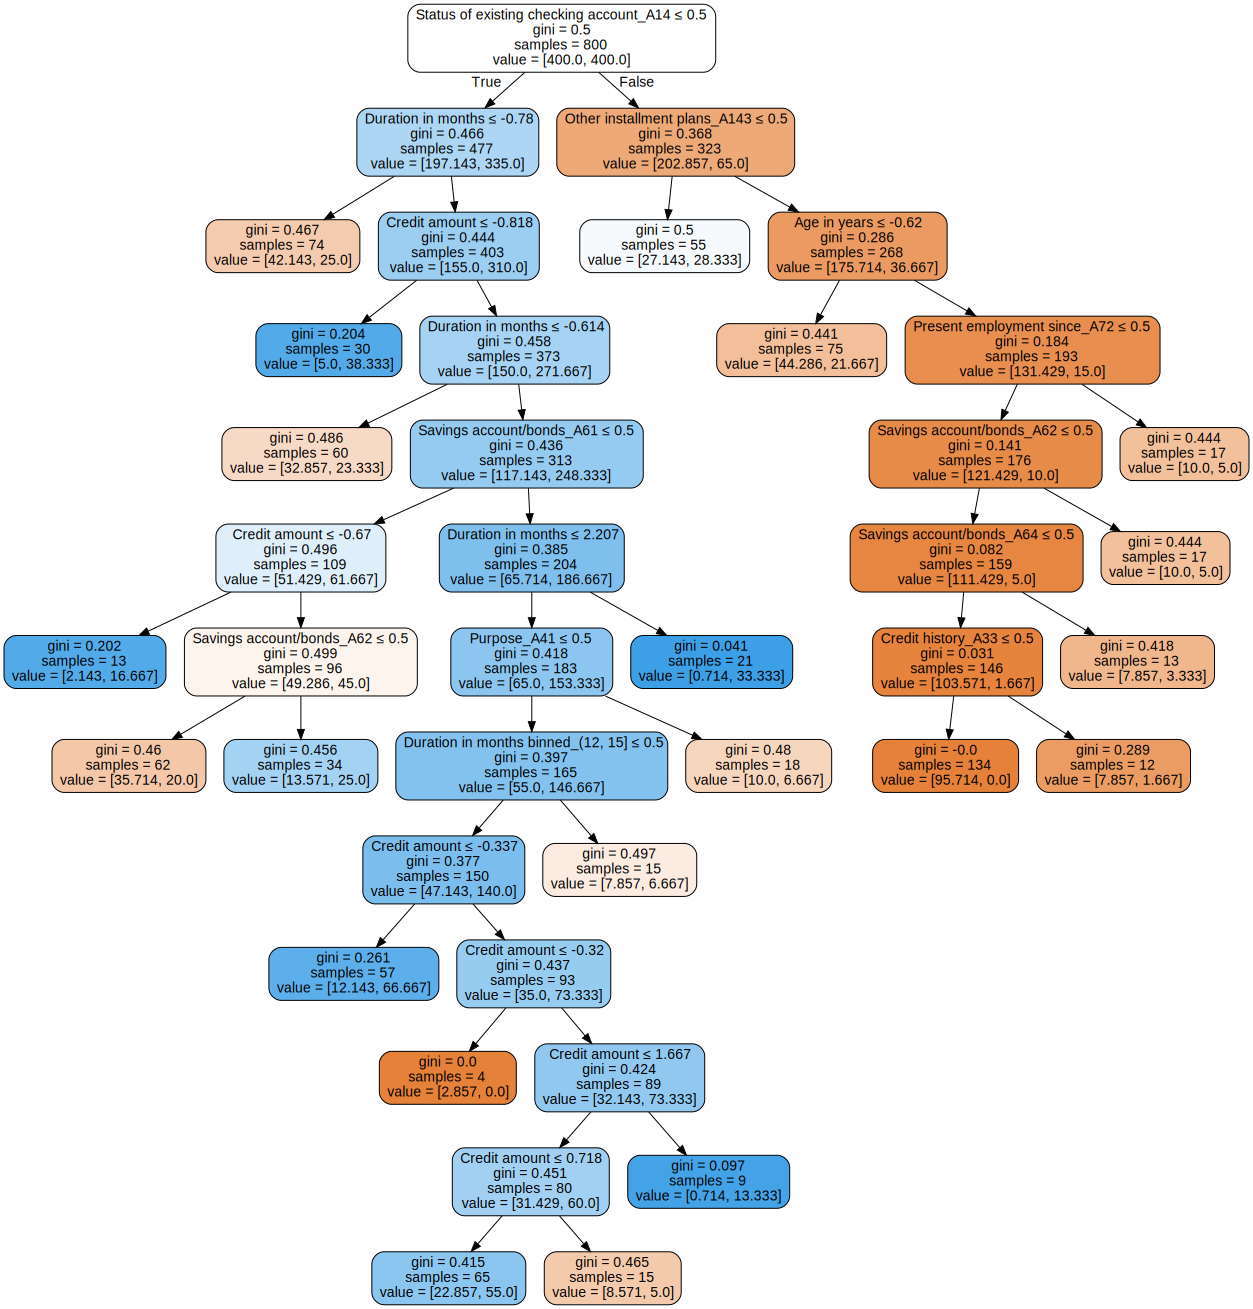

In [75]:
tree_clf2 = DecisionTreeClassifier(min_samples_split=80, class_weight='balanced')
tree_clf2.fit(X, y)
print(roc_auc_score(tree_clf2.predict(X), y))

graph_tree(tree_clf2, attr)

- <code>min_samples_leaf</code> - the minimum number of samples required to be at a leaf node (can be given as a fraction);

0.656589821661592


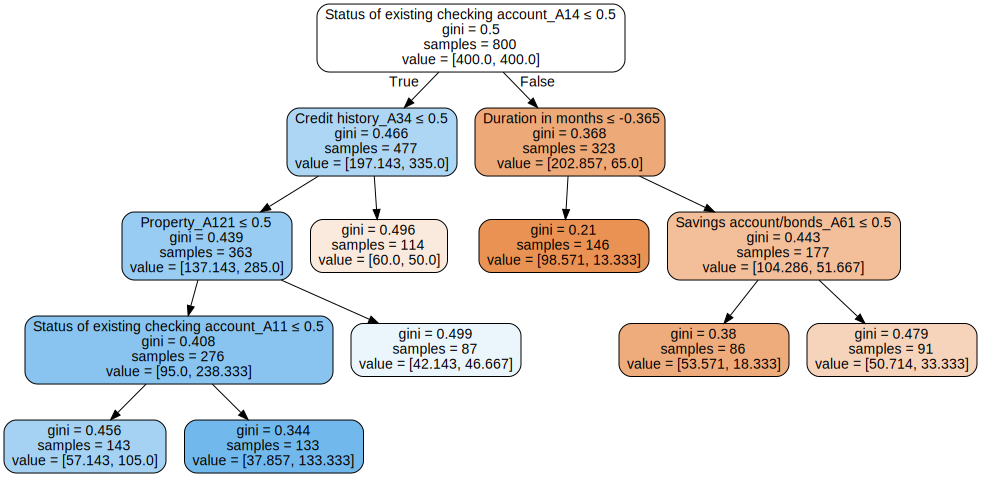

In [76]:
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=80, class_weight='balanced')
#tree_clf2 = DecisionTreeClassifier(min_samples_leaf=0.1)
tree_clf2.fit(X, y)
print(roc_auc_score(tree_clf2.predict(X), y))

graph_tree(tree_clf2, attr)

- <code>min_weight_fraction_leaf</code> - the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node;

0.6729910714285714


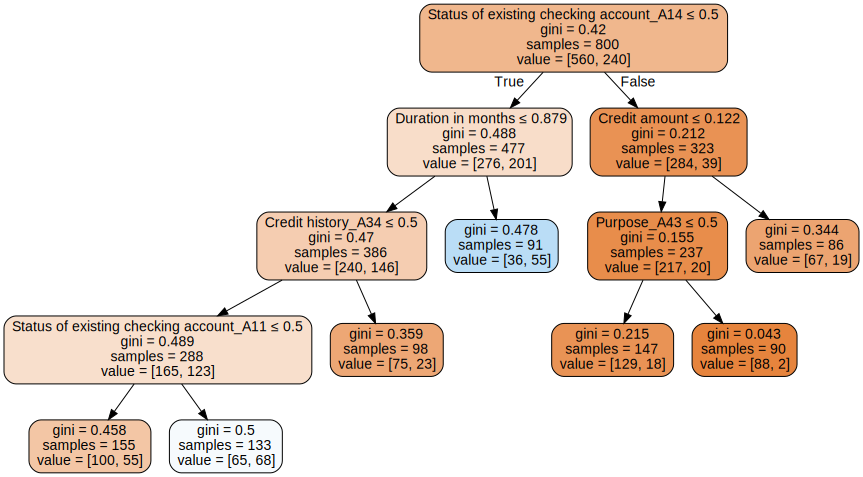

In [77]:
tree_clf2 = DecisionTreeClassifier(min_weight_fraction_leaf=0.1)
tree_clf2.fit(X, y)
print(roc_auc_score(tree_clf2.predict(X), y))

graph_tree(tree_clf2, attr)

- <code>max_features</code> - the number of features to consider when looking for the best split;

1.0


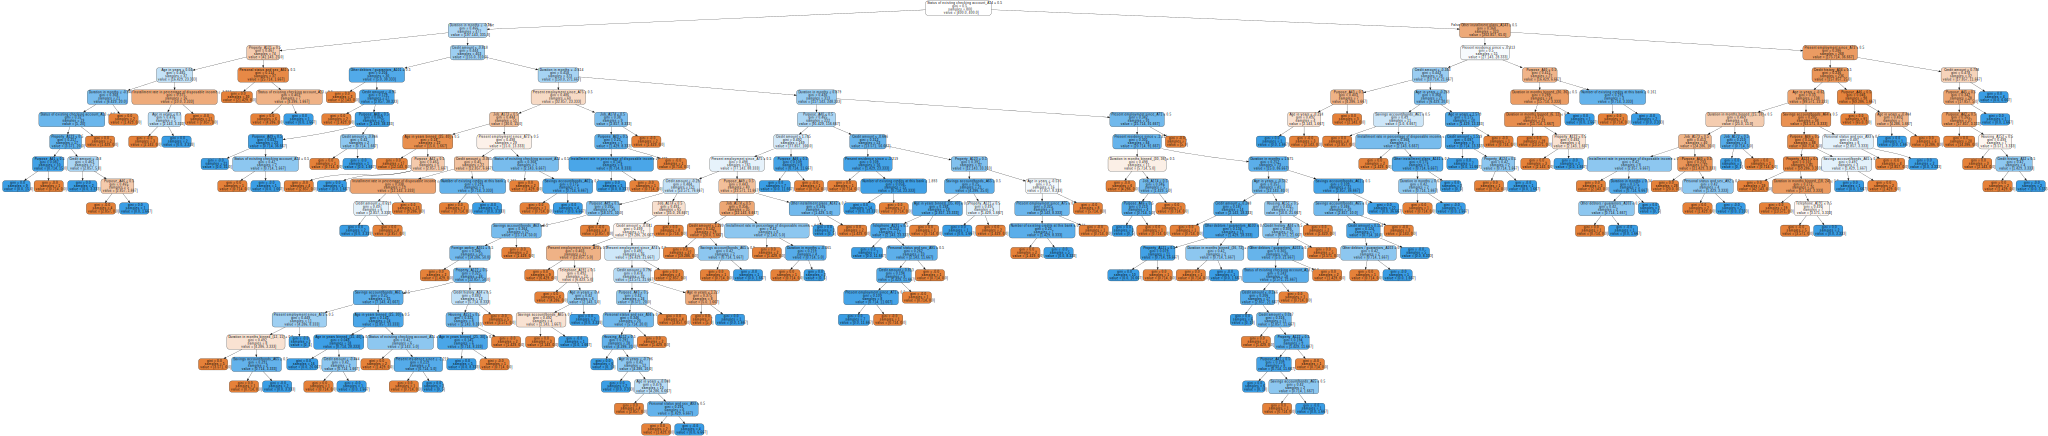

In [78]:
tree_clf2 = DecisionTreeClassifier(max_features=50, class_weight='balanced')
tree_clf2.fit(X, y)
print(roc_auc_score(tree_clf2.predict(X), y))

graph_tree(tree_clf2, attr)

- <code>max_leaf_nodes</code> - grow a tree with <code>max_leaf_nodes</code> in best-first fashion;

0.6675221532725555


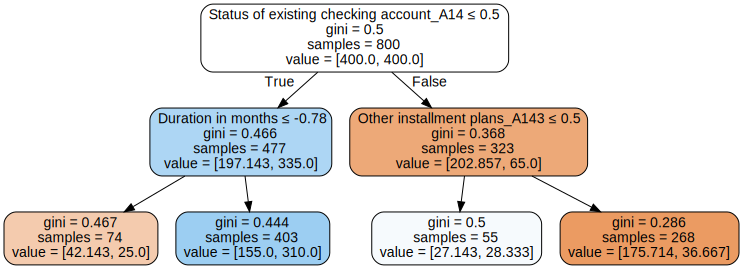

In [79]:
tree_clf2 = DecisionTreeClassifier(max_leaf_nodes=4, class_weight='balanced')
tree_clf2.fit(X, y)
print(roc_auc_score(tree_clf2.predict(X), y))

graph_tree(tree_clf2, attr)

- <code>min_impurity_decrease</code> - a node will be split if this split induces a decrease of the impurity greater than or equal to this value;

0.6814870011591323


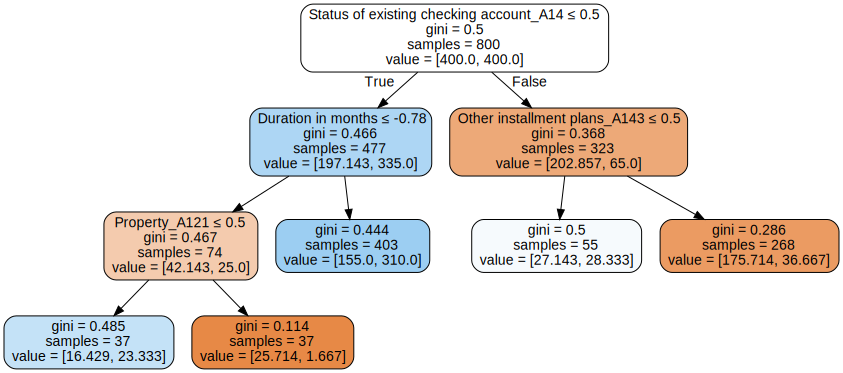

In [80]:
tree_clf2 = DecisionTreeClassifier(min_impurity_decrease=0.01, class_weight='balanced')
tree_clf2.fit(X, y)
print(roc_auc_score(tree_clf2.predict(X), y))

graph_tree(tree_clf2, attr)

- <code>class_weight</code> - weights associated with classes.

## Random Forests - basics

<b>Exercise</b>

Using <code>RandomForestClassifier</code> class train a random forest and compute ROC AUC score. Use two of the regulariztion parameters for decision tree to train your model - a random forest is basically a lot of decision trees. Try also changing the number of trees of your forest using <code>n_estimators</code> parameter.

In [81]:
#Solution
from sklearn.ensemble import RandomForestClassifier

frst_clf = RandomForestClassifier(n_estimators=120, class_weight='balanced', min_samples_split=80, max_depth=4)
frst_clf.fit(X, y)
roc_auc_score(frst_clf.predict(X), y)

0.7309026429551396

Checking which features were the most important for the forest trained above.

In [82]:
feature_importances(frst_clf)

,0
Status of existing checking account_A14,0.141330
Status of existing checking account_A11,0.127573
Credit amount,0.071536
Duration in months,0.065624
Credit history_A34,0.056959


## Gradient Boosting - basics

<b>Exercise</b>

Using <code>GradientBoostingClassifier</code> class train a gradient boosting classifier and compute ROC AUC score. Afterwards, check which features were the most important using <code>feature\_importances\_</code> attribute. You can control learning rate with <code>learning\_rate</code> parameter.

In [83]:
#Solution 1
from sklearn.ensemble import GradientBoostingClassifier

gboost_clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_split=30)
gboost_clf.fit(X, y)
roc_auc_score(gboost_clf.predict(X), y)

0.9690916318823296

In [84]:
#Solution 2
features = pd.DataFrame([gboost_clf.feature_importances_], columns=attr).transpose()
features.sort_values(by=0, ascending=False).head(n=5)

,0
Credit amount,0.171171
Status of existing checking account_A14,0.146974
Duration in months,0.093756
Age in years,0.065725
Credit history_A34,0.029925


## Neural networks - basics

In [85]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier()
nn_clf.fit(X, y)
roc_auc_score(nn_clf.predict(X), y)

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1.0

- <code>hidden_layer_sizes</code> - a tuple with indices indicating number of neurons in hidden layers

<b>Exercise</b>

Using <code>MLPClassifier</code> class train a neural network with 600 neurons in the first hidden layer. Compute ROC AUC score.

In [86]:
nn_clf = MLPClassifier(hidden_layer_sizes=(600,))
nn_clf.fit(X, y)
roc_auc_score(nn_clf.predict(X), y)

1.0

In [87]:
#Basic parameters
nn_clf.n_layers_, nn_clf.n_outputs_, nn_clf.out_activation_

(3, 1, 'logistic')

- <code>activation</code> - activation function from a list \[‘identity’, ‘logistic’, ‘tanh’, ‘relu’\]

<b>Exercise</b>

Using the code from the cell above train a neural network with one of the activation functions above (defualt is 'relu')

In [88]:
#Solution
nn_clf = MLPClassifier(hidden_layer_sizes=(600,), activation='tanh')
nn_clf.fit(X, y)
roc_auc_score(nn_clf.predict(X), y)

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9486566385531693

In [89]:
nn_clf

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(600,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

- <code>learning_rate</code> - defines the learning rate update schedule as per one of the schedules from the list {‘constant’, ‘invscaling’, ‘adaptive’} - 'constant' means no change.

In [90]:
#Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


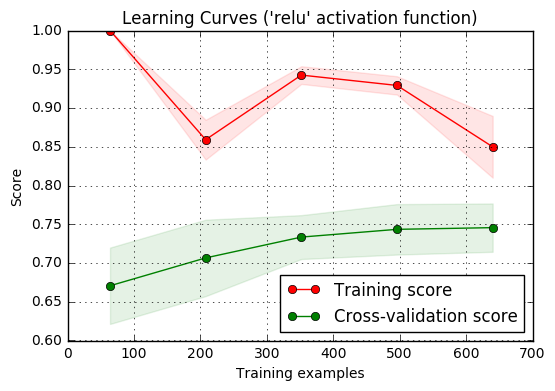

In [91]:
title = "Learning Curves ('tanh' activation function)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

plot_learning_curve(nn_clf, title, X, y, ylim=(0.6, 1), cv=cv, n_jobs=-1)

plt.show()
plt.close()

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


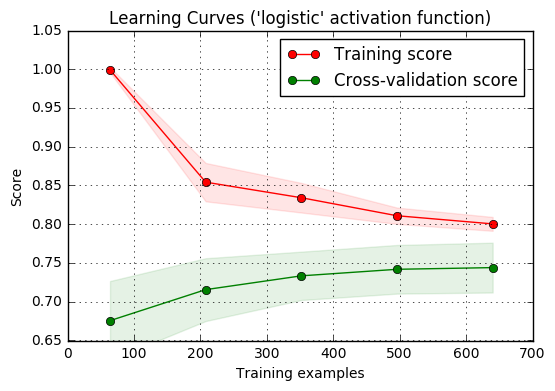

In [95]:
nn_clf1 = MLPClassifier(hidden_layer_sizes=(600,), activation='logistic')
nn_clf.fit(X, y)
#roc_auc_score(nn_clf.predict(X), y)

title = "Learning Curves ('logistic' activation function)"

plot_learning_curve(nn_clf1, title, X, y, ylim=(0.65, 1.05), cv=cv, n_jobs=-1)

plt.show()
plt.close()

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


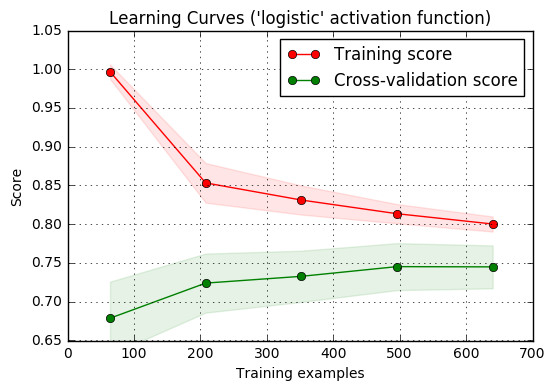

In [97]:
nn_clf1 = MLPClassifier(hidden_layer_sizes=(600,), activation='logistic', learning_rate='invscaling')
nn_clf.fit(X, y)
#roc_auc_score(nn_clf.predict(X), y)

title = "Learning Curves ('logistic' activation function)"

plot_learning_curve(nn_clf1, title, X, y, ylim=(0.65, 1.05), cv=cv, n_jobs=-1)

plt.show()
plt.close()

- <code>max_iter</code> - terminate learning after specified amount of iterations;

<b>Exercise</b>

Train a neural network with <code>max_iter</code>

In [98]:
#Solution
nn_clf2 = MLPClassifier(hidden_layer_sizes=(600,), activation='tanh', max_iter=5000)
nn_clf.fit(X, y)
roc_auc_score(nn_clf.predict(X), y)

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9504908086357172

## SVM - basics

<b>Exercise</b>

Using <code>SVC</code> class train supporting vector machine and compute ROC AUC score.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(class_weight='balanced')
svm_clf.fit(X, y)
roc_auc_score(svm_clf.predict(X), y)

# Validation techniques

## Out-of-sample validation

<b>Exercise</b>

Using <code>test_train_split</code> function split the <code>train_data</code> set into <code>train_in_sample</code> and <code>train_out_of_sample</code> sets, split them into <code>X_is, X_oos, y_is, y_os</code> with 80-20 proportion.

In [99]:
#Solution
train_in_sample, train_out_of_sample = train_test_split(train_data, test_size=0.2, random_state=0, 
                                                        stratify=train_data["Good flag"])

attr = list(train_data.columns.copy())
attr.remove("Good flag")

X_is = train_in_sample[attr].values
y_is = train_in_sample["Good flag"].values
X_oos = train_out_of_sample[attr].values
y_oos = train_out_of_sample["Good flag"].values

<b>Exercise</b>

Choose a classifying algorithm and train in on the in-sample set produced above. Using <code>predict()</code> method compute ROC AUC score on the in-sample and out-of-sample sets.

Compare your results with other colleagues who used the same algorithm.

In [100]:
#Solution

frst_clf2 = RandomForestClassifier()
frst_clf2.fit(X_is, y_is)
print("The ROC AUC score on the in-sample is: ", roc_auc_score(frst_clf2.predict(X_is), y_is),"\n",
     "The ROC AUC score on the out-of-sample is: ", roc_auc_score(frst_clf2.predict(X_oos), y_oos),".")

The ROC AUC score on the in-sample is:  0.9869565217391305 
 The ROC AUC score on the out-of-sample is:  0.7599753187988482 .


C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## K-fold validation

In [101]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

In [102]:
for index, (train_index, test_index) in enumerate(skf.split(X, y)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    tree_clf2.fit(X_train, y_train)
    
    print("The in-sample ROC AUC score for the ", index, "split is ", 
          roc_auc_score(tree_clf2.predict(X_train), y_train), ".")
    print("The out-of-sample ROC AUC score for the ", index, "split is ", 
          roc_auc_score(tree_clf2.predict(X_test), y_test), ".")
    print("\n")

The in-sample ROC AUC score for the  0 split is  0.6638448043735465 .
The out-of-sample ROC AUC score for the  0 split is  0.6619433198380567 .


The in-sample ROC AUC score for the  1 split is  0.6894353369763205 .
The out-of-sample ROC AUC score for the  1 split is  0.6364464315283986 .


The in-sample ROC AUC score for the  2 split is  0.6891625615763548 .
The out-of-sample ROC AUC score for the  2 split is  0.6015873015873016 .


The in-sample ROC AUC score for the  3 split is  0.6775277387091733 .
The out-of-sample ROC AUC score for the  3 split is  0.644313725490196 .


The in-sample ROC AUC score for the  4 split is  0.6891359414579229 .
The out-of-sample ROC AUC score for the  4 split is  0.6618092052874662 .




<b>Exercise</b>

Validate any of the algorithms discussed above and decide whether it's better than the decision tree trained above using average ROC AUC score from the out-of-sample.

In [103]:
nn_clf = MLPClassifier(hidden_layer_sizes=(600,), activation='tanh')

for index, (train_index, test_index) in enumerate(skf.split(X, y)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    nn_clf.fit(X_train, y_train)
    
    print("The in-sample ROC AUC score for the ", index, "split is ", 
          roc_auc_score(nn_clf.predict(X_train), y_train), ".")
    print("The out-of-sample ROC AUC score for the ", index, "split is ", 
          roc_auc_score(nn_clf.predict(X_test), y_test), ".")
    print("\n")

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The in-sample ROC AUC score for the  0 split is  0.8537414965986394 .
The out-of-sample ROC AUC score for the  0 split is  0.711548839719374 .


The in-sample ROC AUC score for the  1 split is  0.7697318007662834 .
The out-of-sample ROC AUC score for the  1 split is  0.6540385096274068 .




C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The in-sample ROC AUC score for the  2 split is  0.8748792270531401 .
The out-of-sample ROC AUC score for the  2 split is  0.7410329985652798 .


The in-sample ROC AUC score for the  3 split is  0.7715323609339471 .
The out-of-sample ROC AUC score for the  3 split is  0.7163009404388716 .


The in-sample ROC AUC score for the  4 split is  0.8933691756272402 .
The out-of-sample ROC AUC score for the  4 split is  0.6484037963761863 .




C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Parameter grids

In [104]:
param_grid_tree = [
    {'splitter': ['best', 'random'], 'max_depth': [2, 4, 6, 8]},
    {'splitter': ['best', 'random'], 'min_samples_split': [2, 6, 10, 16]},
    {'splitter': ['best', 'random'], 'min_samples_leaf': [1, 2, 4]},
    {'splitter': ['best', 'random'], 'max_features': [10, "auto", "sqrt", None]},
    {'splitter': ['best', 'random'], 'max_leaf_nodes': [50, 100, 150]}
]

In [105]:
from sklearn.model_selection import GridSearchCV

grd_tree = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid_tree,
                        cv=5, scoring='roc_auc')

In [106]:
grd_tree.fit(X, y)
grd_tree.best_score_

0.6955729166666665

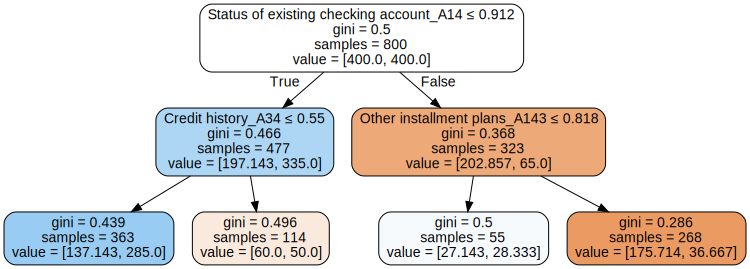

In [107]:
graph_tree(grd_tree.best_estimator_,attr)

<b>Exercise</b>

Try out some combinations of regularization parameters. Check which parameters were chosen!

0.7097470238095238
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')


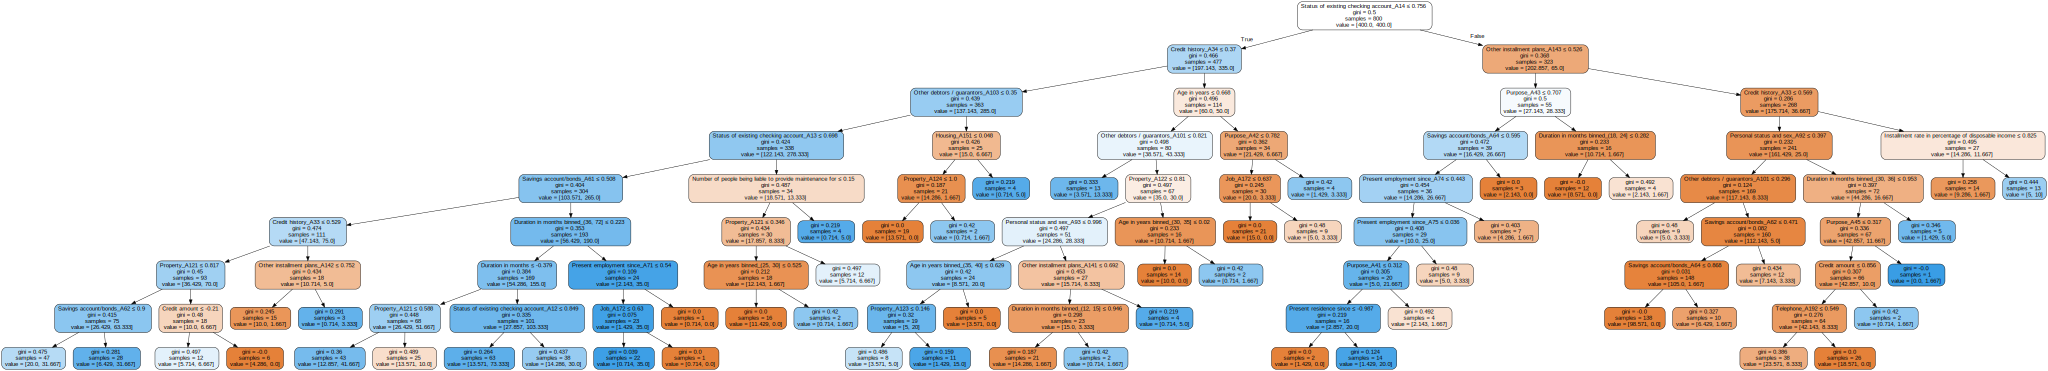

In [108]:
#Solution
param_grid_tree = [
    {'splitter': ['best', 'random'], 'max_depth': [2, 4, 6, 8], 'min_samples_split': [2, 6, 10, 16]},
    {'splitter': ['best', 'random'], 'min_samples_leaf': [1, 2, 4], 'max_features': [10, "auto", "sqrt", None]},
    {'splitter': ['best', 'random'], 'max_leaf_nodes': [50, 100, 150]}
]

grd_tree = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid_tree,
                        cv=5, scoring='roc_auc')

grd_tree.fit(X, y)
print(grd_tree.best_score_)
print(grd_tree.best_estimator_)

graph_tree(grd_tree.best_estimator_,attr)

<b>Exercise</b>

Eperiment with <code>RandomForestClassifier</code> and <code>GradientBoostingClassifier</code>. Check what best results you can get.

In [109]:
#Solution
param_grid_frst = [
    {'bootstrap': [True, False], 'n_estimators': [10, 30, 50, 100], 'max_depth': [2, 4, 6, 8]},
    {'bootstrap': [True, False], 'n_estimators': [10, 30, 50, 100], 'min_samples_split': [2, 6, 10, 16]},
    {'bootstrap': [True, False], 'n_estimators': [10, 30, 50, 100], 'min_samples_leaf': [1, 2, 4]},
    {'bootstrap': [True, False], 'n_estimators': [10, 30, 50, 100], 'max_features': [10, "auto", "sqrt", None]},
    {'bootstrap': [True, False], 'n_estimators': [10, 30, 50, 100], 'max_leaf_nodes': [50, 100, 150]}
]

from sklearn.ensemble import RandomForestClassifier

grd_frst = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid_frst,
                        cv=5, scoring='roc_auc')

grd_frst.fit(X, y)
print(grd_frst)
print(grd_frst.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [2, 4, 6, 8], 'n_estimators': [10, 30, 50, 100], 'bootstrap': [True, False]}, {'n_estimators': [10, 30, 50, 100], 'bootstrap': [True, False], 'min_samples_split': [2, 6, 10, 16]}, {'min_samples_leaf': [1, 2, 4], 'n_estimators': [10, 30, 50, 100], 'bootstrap': [True, False]}..., {'max_leaf_nodes': [50, 100, 150], 'n_estimators': [10, 30, 50, 100], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', ref

In [110]:
param_grd_gboost = [
    {'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [10, 25, 100],
    'subsample': [0.7, 0.85, 1], 'min_samples_split': [2, 6, 16], 'max_depth': [2, 4, 6]},
    {'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [10, 25, 100],
    'subsample': [0.7, 0.85, 1], 'max_features': [10, "auto", "sqrt", None]}
]

from sklearn.ensemble import GradientBoostingClassifier

grd_gboost = GridSearchCV(GradientBoostingClassifier(), param_grd_gboost,
                        cv=5, scoring='roc_auc')

grd_gboost.fit(X, y)
print(grd_gboost)
print(grd_gboost.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'learning_rate': [0.001, 0.01, 0.1], 'min_samples_split': [2, 6, 16], 'max_depth': [2, 4, 6], 'n_estimators': [10, 25, 100], 'subsample': [0.7, 0.85, 1]}, {'max_features': [10, 'auto', 'sqrt', None], 'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [10, 25, 100], 'subsample': [0.7, 0.85, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
0.8075520833333332


# Pipelines

In [145]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class DataSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr_names):
        self.attr_names = attr_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attr_names].values
    
class DataDummy(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dummy = pd.get_dummies(pd.DataFrame(X), dummy_na=True)
        return dummy.values

In [147]:
from sklearn.pipeline import Pipeline, FeatureUnion

num_pipeline = Pipeline([
    ('select_attr', DataSelector(numeric_vars)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('select_attr', DataSelector(cat_vars)),
    ('scaler', DataDummy())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipe', num_pipeline),
    ('cat_pipe', cat_pipeline)
])

data_prepared = full_pipeline.fit_transform(raw_data)

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [148]:
data_prepared

array([[-1.23647786, -0.74513141,  0.91847717, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.24819436,  0.94981679, -0.87018333, ...,  0.        ,
         0.        ,  0.        ],
       [-0.73866754, -0.41656241, -0.87018333, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.73866754, -0.87450324,  0.91847717, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.9992892 , -0.50552769,  0.91847717, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.9992892 ,  0.46245715,  0.02414692, ...,  0.        ,
         0.        ,  0.        ]])